# Project 2: Continuous Control

---
**Author: Jason Zeng**

**Date: April 24, 2020**

For this project, we will work with the [Reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) environment. Here is a view of the Unity ML-Agents Researcher environment.

![Alt text](https://video.udacity-data.com/topher/2018/June/5b1ea778_reacher/reacher.gif)

In this Unity ML-Agents Researcher environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

#### Distributed Training:
There are two separate versions of the Unity environment provided:
- The first version contains a single agent.
- The second version contains 20 identical agents, each with its own copy of the environment.

The second version is useful for algorithms like PPO, A3C, and D4PG that use multiple (non-interacting, parallel) copies of the same agent to distribute the task of gathering experience.

#### Solving the Environment:
###### Option 1: Solve the First Version
The task is episodic, and in order to solve the environment, your agent must get an average score of +30 over 100 consecutive episodes.

###### Option 2: Solve the Second Version
The barrier for solving the second version of the environment is slightly different, to take into account the presence of many agents. In particular, your agents must get an average score of +30 (over 100 consecutive episodes, and over all agents). Specifically,

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 20 (potentially different) scores. We then take the average of these 20 scores.
- This yields an average score for each episode (where the average is over all 20 agents).

As an example, consider the plot below, where we have plotted the average score (over all 20 agents) obtained with each episode.
![Alt text](https://video.udacity-data.com/topher/2018/July/5b48f845_unknown/unknown.png)

The environment is considered solved, when the average (over 100 episodes) of those average scores is at least +30. In the case of the plot above, the environment was solved at episode 63, since the average of the average scores from episodes 64 to 163 (inclusive) was greater than +30.

Next, we will take **Option 2** to train the agents for the project.  

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

We select version 2 (with 20 agents) of the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In the given environment, there are altogether 33 variables in the observation space. Those include position, velocity, rotation, and angular velocity of the arm. The action space is a vector of 4 numbers, with each taking value between -1 and 1. These 4 numbers are related to torque applied to the 2 joints. 

A reward of 0.1 will be given for each step that the agent's hand is in the target location. This means the agent's goal will be to maintain its position at the target location as long as possible.

The code cell below will print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0824999981559813


When finished, you can close the environment.

In [ ]:
#env.close()

### 4. Train Agents with DDPG

One of the limitations of the DQN agent is that it is not straightforward to use in continuous action spaces. DDPG algorithm, with details in this [paper](https://arxiv.org/abs/1509.02971), can help to address this issue. 

In DDPG, we use two deep neural networks, one called actor, one called critic. So DDPG is also known as 'Actor-Critic' method. The critic in DDPG is used to approximate the maximizer over the Q values of the next state, and not as a learned baseline. 
The actor is used to approximate the optimal policy deterministically. That means we want to always output the best believed action for any given state. This is unlike a stochastic policies in which we want the policy to learn a probability distribution over the actions. 

Overview of NN structure:

- A two-hidden-layer NN for both "Actor" and "Critic".
- Layer 1 has 256 nodes and Layer 2 has 128 nodes.
- State size is 33.
- Action size is 4.
- Activation function ReLU is used in all layers.

Summary of key model parameters:
```python
BUFFER_SIZE = int(1e6) # replay buffer size
BATCH_SIZE = 128 # minibatch size
GAMMA = 0.95 # discount factor
TAU = 1e-3 # for soft update of target parameters
LR_ACTOR = 1e-4 # learning rate of the actor
LR_CRITIC = 1e-3 # learning rate of the critic
WEIGHT_DECAY = 0 # L2 weight decay
UPDATE_EVERY = 20 # how often to update the network
UPDATE_TIMES = 10 # how many times to update the network each time
EPSILON = 1.0 # epsilon for the noise process added to the actions
EPSILON_DECAY = 1e-6 # decay for epsilon above
```

Now it's our turn to train our own agent to solve the environment!

A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- In this coding environment, we will not be able to watch the agents while they are training.  However, **_after training the agents_**, we can download the saved model weights to watch the agents on your own machine! 

In [8]:
# load relevant packages
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

from workspace_utils import active_session # keep session active

#### 4.1 Define PPDG function

In [9]:
# PPDG
def ddpg(n_episodes=5000, max_t=1000, reset_time=100, print_every=100, state_size=33, action_size=4, random_seed=2):
    # agent
    agent = Agent(state_size, action_size, random_seed)
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        for t in range(max_t):
        #while True:
            if t % reset_time == 0:
                agent.reset()
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            for i_agent in range(num_agents):
                agent.step(states[i_agent], actions[i_agent], rewards[i_agent], 
                           next_states[i_agent], dones[i_agent])# update the system
            score += rewards                                   # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        # Keep higher threshold during training
        if np.mean(scores_deque) > (35.0):
            print('\nEnvironment solved in {} episodes.\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            break
            
    return scores

#### 4.2 Training

In [10]:
with active_session():
    # do long-running work here
    scores = ddpg()

Episode 100	Average Score: 19.24
Episode 159	Average Score: 35.05
Environment solved in 159 episodes.	Average Score: 35.050


Comment: this process takes ~10 hours to run. 

#### 4.3 Plot QC

Text(0,0.5,'Score')

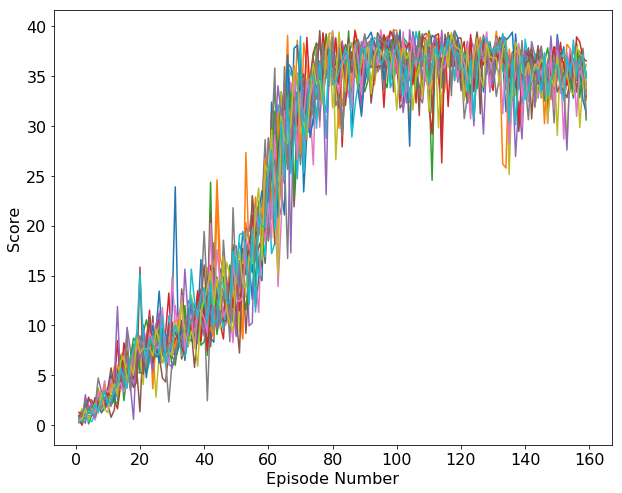

In [15]:
import matplotlib
fig = plt.figure(figsize=(10, 8))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(np.arange(1, len(scores)+1), scores)
plt.xlabel('Episode Number')
plt.ylabel('Score')

### 5. Summary and Discussion

In this notebook, we have successfully used 'Actor-Critic' algorithm DDPG to train a total of 20 agents to solve the Researcher problem. The environment solved in 159 episodes with an average score of 35.050. 

A few ways to further improve:

- Hyperparameter tuning, including  ϵ -decay rate, discount factor, update frequency etc.
- Apply DDPM improvements, including **_Important Sampling_**, **_Proximal Policy Optimization (PPO)_**, **_Advantage Actor Critic (A2C)_** and **_Generalized Advantage Estimation (GAE)_**.